# TensorFlow Transfer Learning Fine-tuning

In [120]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import random
import os

from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
# from tensorflow.keras.layers import Rescaling # Se for utilizar um modelo que não tenha escalonamento interno, como ResNet50V2, é necessário escalonar os dados.
from tensorflow.keras.layers import RandomFlip, RandomHeight, RandomRotation, RandomWidth, RandomZoom
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory

## Setup

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-darkgrid')

### Constantes

In [3]:
SEMENTE = 2008193

DIR_TREINO    = '10_food_classes_all_data/train'
DIR_TREINO_10 = '10_food_classes_10_percent/train'
DIR_TREINO_1  = '10_food_classes_1_percent/train'
DIR_TESTE     = '10_food_classes_all_data/test'

TAMANHO_LOTE = 32
FORMATO_IMAGEM = (224, 224)
MODO_CLASSE = 'categorical'

FORMATO_ENTRADA = FORMATO_IMAGEM + (3,)
ATIVACAO = 'softmax'

PERDA = 'categorical_crossentropy'
METRICAS = ['accuracy']

# OTIMIZADOR = 'Adam'
# APRENDIZADO = 0.001

### Funções

In [4]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py

--2023-01-23 14:49:20--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4049 (4.0K) [text/plain]
Saving to: ‘funcoes.py’

funcoes.py          100%[===================>]   3.95K  --.-KB/s    in 0s      

2023-01-23 14:49:20 (65.8 MB/s) - ‘funcoes.py’ saved [4049/4049]



In [5]:
from funcoes import criar_callback_tensorboard, grafico_perda_precisao_por_iteracao, unzip_data, walk_through_dir

## Dados

In [6]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data('10_food_classes_all_data.zip')
unzip_data('10_food_classes_10_percent.zip')
unzip_data('10_food_classes_1_percent.zip')

--2023-01-23 14:49:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.103.128, 108.177.120.128, 142.250.159.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.103.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  88.7MB/s    in 5.6s    

2023-01-23 14:49:26 (88.9 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]

--2023-01-23 14:49:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.103.128, 108.177.120.128, 142.250.159.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.103.128|:443... connected.
HTTP request sent, awaiting response... 20

In [7]:
# walk_through_dir('10_food_classes_all_data')

### Importando os dados e tranformando-os em lotes

In [8]:
dados_treino = image_dataset_from_directory(directory=DIR_TREINO,
                                            batch_size=TAMANHO_LOTE,
                                            image_size=FORMATO_IMAGEM,
                                            label_mode=MODO_CLASSE,
                                            seed=SEMENTE)

dados_teste = image_dataset_from_directory(directory=DIR_TESTE,
                                           batch_size=TAMANHO_LOTE,
                                           image_size=FORMATO_IMAGEM,
                                           label_mode=MODO_CLASSE,
                                           seed=SEMENTE)

dados_treino_10 = image_dataset_from_directory(directory=DIR_TREINO_10,
                                               batch_size=TAMANHO_LOTE,
                                               image_size=FORMATO_IMAGEM,
                                               label_mode=MODO_CLASSE,
                                               seed=SEMENTE)

dados_treino_1 = image_dataset_from_directory(directory=DIR_TREINO_1,
                                              batch_size=TAMANHO_LOTE,
                                              image_size=FORMATO_IMAGEM,
                                              label_mode=MODO_CLASSE,
                                              seed=SEMENTE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
Found 750 files belonging to 10 classes.
Found 70 files belonging to 10 classes.


In [9]:
# image_dataset_from_directory retorna um BatchDataset

# O primeiro tensor contém as imagens. DADOS NÃO ESCALONADOS.
# O tamanho do lote não está especificado, mesmo que tenha sido informado.
# Os canais de cores estão definidos pelo parâmetro color_mode='rgb' (default).

# O segundo tensor contém as classes em formato one-hot.

dados_treino

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
rotulos = dados_treino.class_names
# rotulos

## Criando Modelo_00

The Functional API: https://www.tensorflow.org/guide/keras/functional

Modelos pré-treinados: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [11]:
# Criar um modelo-base a partir de um modelo pré-treinado.
# EfficientNetB0 foi treinado com a ImageNet, portanto a camada no topo tem 1000 entradas.
# Nossos dados possuem 10 classes, portanto não utilizaremos a camada no topo padrão. (include_top=False)
modelo_base = EfficientNetB0(include_top=False)

# "Congelar" o modelo-base, para que os padrões pré-treinados não sejam odificados durante o treinamento.
modelo_base.trainable = False

# Camada de entrada.
entradas = Input(shape=FORMATO_ENTRADA, name='camada_entrada')

# Se for utilizar um modelo que não tenha escalonamento interno, como ResNet50V2, é necessário escalonar os dados.
# Modelos EfficientNet possuem escalonamento interno.
# camadas = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(entradas)
# Obs.: acredito que a camada de escalonamento devia ser adicionada à 'entradas', não 'camadas'.

# Carregar as entradas no modelo-base.
camadas = modelo_base(entradas)

# Agrupar a média global do modelo-base.
# Esta camada cria o vetor de características (feature vector).
camadas = GlobalAveragePooling2D(name='agrupamento_media_global')(camadas)

# Camada de saída.
saidas = Dense(len(rotulos), activation=ATIVACAO, name='camada_saida')(camadas)

# Reunir camadas de entrada e saída em um modelo.
modelo_00 = Model(inputs=entradas, outputs=saidas, name='Modelo_00')

# Compilar o modelo.
modelo_00.compile(loss=PERDA, optimizer=Adam(), metrics=METRICAS)

# Ajustar o modelo, gravando histórico e criando logs TensorBoard.
historico_00 = modelo_00.fit(dados_treino_10,
                             epochs=5,
                             steps_per_epoch=len(dados_treino_10),
                             validation_data=dados_teste,
                             validation_steps=len(dados_teste),
                             callbacks=[criar_callback_tensorboard(diretorio='transfer_learning',
                                                                   experimento='modelo_00_10_por_cento')],
                             verbose=1)

16705208/16705208 [==============================] - 0s 0us/step
Salvando log TensorBoard em: 'transfer_learning/modelo_00_10_por_cento/20230123-144958'.
Epoch 1/5
24/24 [==============================] - 23s 405ms/step - loss: 1.9133 - accuracy: 0.4200 - val_loss: 1.3123 - val_accuracy: 0.7364
Epoch 2/5
24/24 [==============================] - 8s 320ms/step - loss: 1.1027 - accuracy: 0.7480 - val_loss: 0.8757 - val_accuracy: 0.8200
Epoch 3/5
24/24 [==============================] - 8s 319ms/step - loss: 0.7923 - accuracy: 0.8133 - val_loss: 0.6945 - val_accuracy: 0.8496
Epoch 4/5
24/24 [==============================] - 8s 320ms/step - loss: 0.6353 - accuracy: 0.8627 - val_loss: 0.6089 - val_accuracy: 0.8620
Epoch 5/5
24/24 [==============================] - 8s 333ms/step - loss: 0.5600 - accuracy: 0.8680 - val_loss: 0.5533 - val_accuracy: 0.8668


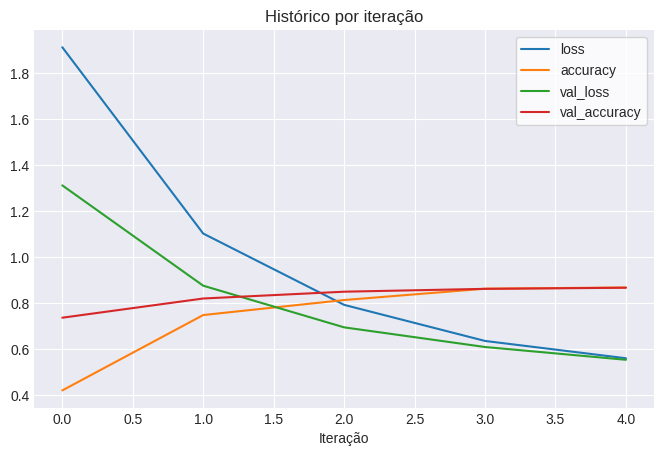

In [12]:
grafico_perda_precisao_por_iteracao(historico_00)

In [13]:
modelo_00.summary()

Model: "Modelo_00"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 camada_entrada (InputLayer)  [(None, 224, 224, 3)]    0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 agrupamento_media_global (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 camada_saida (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation 
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentaton 
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation 

> 🔑 **Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

## Criando Modelo_01

### Expandindo dados

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers 

Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of imges (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [121]:
expansao_dados = Sequential(name="expansao_dados")

# expansao_dados.add(Rescaling(1./255)) # Se for utilizar um modelo que não tenha escalonamento interno, como ResNet50V2, é necessário escalonar os dados.

expansao_dados.add(RandomFlip('horizontal'))
expansao_dados.add(RandomRotation(0.2))
expansao_dados.add(RandomZoom(0.2))
expansao_dados.add(RandomHeight(0.2))
expansao_dados.add(RandomWidth(0.2))

#### Visualizando dados expandidos

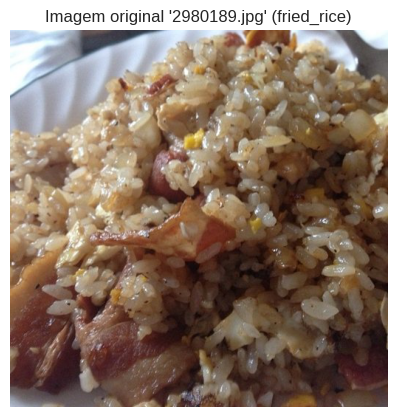

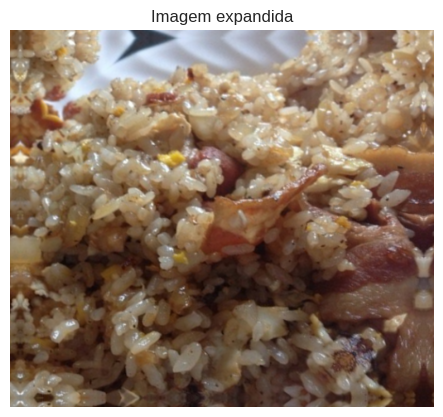

In [126]:
from tensorflow.python import training
classe_aleatoria = random.choice(rotulos)
caminho_classe   = DIR_TREINO_1 + '/' + classe_aleatoria
imagem_aleatoria = random.choice(os.listdir(caminho_classe))
caminho_imagem   = caminho_classe + '/' + imagem_aleatoria

imagem = mpimg.imread(caminho_imagem)

# imagem_expandida = expansao_dados(tf.expand_dims(imagem, axis=0))
# Há um bug na versão 2.8 do TensorFlow que faz necessário forçar o treinamento para que a expansão dos dados funcione.
imagem_expandida = expansao_dados(tf.expand_dims(imagem, axis=0), training=True)

plt.title(f"Imagem original '{imagem_aleatoria}' ({classe_aleatoria})")
plt.imshow(imagem)
plt.axis(False)
plt.show()

plt.title(f"Imagem expandida")
# plt.imshow(tf.squeeze(imagem_expandida))
plt.imshow(tf.divide(tf.squeeze(imagem_expandida), 255.)) # Escalonamento para visualização
plt.axis(False)
plt.show()